## Elo Merchant Category Recommendation
### Supervised Learning: Predict customer loyalty given credit card transactions data

----
**Project Overview**
Elo is a payment solution in Brazil, who partners with merchants to offer promotions to cardholders. Elo adds value to the merchants and the cardholders when the cardholders gets the discounts they highly value and end up spending with the merchants, who will see an increase in revenue. Therefore, it
s highly important to provide targeted promotions to the most relevant group of cardholders. One dimension to segment cardholder is based on loyalty score, and Elo has called for the data science community on Kaggle to help predict customer loyalty score given historical credit card transactions data. 

**Problem Statement**
This project's goal is to predict credit card id level loyalty score given historical credit card transations. It is unclear how customer loyalty is defined, but given the dataset, it's a numeric value centered around 0. It likely represents a score, the higher means there is more value associated with the customer. It can also represent the predicted revenue that will come from the customer in a future period given information on historical transactions.To work towards a solution, the first step is to identify what features associated with the card owner and historical transactions are most impactful on the loyalty score. A good starting hypothesis is that high spenders, frequent spenders, spenders that don't get transactions declined, buyers of certain goodies, in certain geo locations, longer-term card holders, etc. are more likely to have higher customer loyalty. After the feature engineering stage, the next step is to empirically evaluate which features are highly relevant for the model. Regression models are likely good options, since the desired output is a continuous numeric loyalty score.

**Success Metric**
Elo provides a test dataset with a target customer loyalty score, serving as the "ground truth". The goal is to minimize the root mean sqaured error, which compares the predicted loyalty score for each card_id and the actual loyalty score assigned to the card_id.

In [69]:
import pandas as pd
import numpy as np
import sys
def read_csv(file):
    return pd.read_csv(r'/Users/anxia/Documents/mlnd_capstone_data/' + file)

import seaborn as sns
sns.set_style('white')

import datetime
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

----
## Exploring the data

In [3]:
train = read_csv(r'train.csv')
historical_transactions = read_csv(r'historical_transactions.csv')
new_merchant_transactions = read_csv(r'new_merchant_transactions.csv')
merchants = read_csv(r'merchants.csv')
test = read_csv(r'test.csv')

In [4]:
# Number of records
n_records_train = train.shape[0]
n_records_test = test.shape[0]
n_records_hist_trans = historical_transactions.shape[0]
n_records_new_trans = new_merchant_transactions.shape[0]
n_records_merchants = merchants.shape[0]

print("Total number of records")
print("Training data: {}".format(n_records_train))
print("Test data: {}".format(n_records_test))
print("Historical transactions: {}".format(n_records_hist_trans))
print("New transactions: {}".format(n_records_new_trans))
print("Merchants: {}".format(n_records_merchants))

Total number of records
Training data: 201917
Test data: 123623
Historical transactions: 29112361
New transactions: 1963031
Merchants: 334696


In [122]:
# Show an example of each dataset
print("Train")
display(train.head(n = 1))
print("Historical Transactions")
display(historical_transactions.head(n = 1))
print("New Merchant Transactions")
display(new_merchant_transactions.head(n = 1))
print("Merchants")
display(merchants.head(n = 1))

Train


,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,target_win
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,-0.820283


Historical Transactions


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37


New Merchant Transactions


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19


Merchants


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.4,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0


In [121]:
list(historical_transactions)

['authorized_flag',
 'card_id',
 'city_id',
 'category_1',
 'installments',
 'category_3',
 'merchant_category_id',
 'merchant_id',
 'month_lag',
 'purchase_amount',
 'purchase_date',
 'category_2',
 'state_id',
 'subsector_id']

** Features of interest **
- Purchase amount: Total, L30, L60, L90, Average per transaction
- Number of transactions: Total, L30, L60, L90
- First active month: card tenure
- Proportion of authorized/declined transactions
- Transactions by categories
- Transactions by merchants
- Tranactions by state_id, city_id
- Transactions by subsector_id
- Total/proportion of transactions with installments

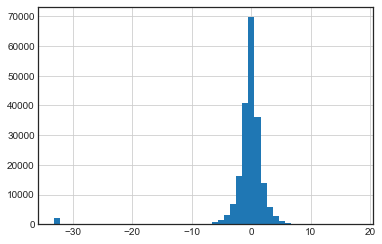

In [6]:
# Visualize target variable distribution
train.target.hist(bins=50)

**Explore target scores based on sample cards with: high, median, low, zero target scores**

In [7]:
print("Sample Card - High score")
high_sample_hist_trans = historical_transactions[historical_transactions['card_id']=='C_ID_648406c4c7'].reset_index(drop=True)
# display(high_sample_hist_trans.head(n=3))
print('total transactions:', high_sample_hist_trans['purchase_date'].count() )
print('% of decline:', round(high_sample_hist_trans[high_sample_hist_trans['authorized_flag']=='N']['purchase_date'].count()/high_sample_hist_trans['purchase_date'].count(),2))

Sample Card - High score
total transactions: 72
% of decline: 0.22


In [8]:
print("Sample Card - Median score")
median_sample_hist_trans = historical_transactions[historical_transactions['card_id']=='C_ID_92a2005557'].reset_index(drop=True)
# display(median_sample_hist_trans.head(n=3))
print('total transactions:', median_sample_hist_trans['purchase_date'].count() )
print('% of decline:', round(median_sample_hist_trans[median_sample_hist_trans['authorized_flag']=='N']['purchase_date'].count()/median_sample_hist_trans['purchase_date'].count(),2))

Sample Card - Median score
total transactions: 260
% of decline: 0.05


In [9]:
print("Sample Card - Low score")
low_sample_hist_trans = historical_transactions[historical_transactions['card_id']=='C_ID_c2ecf46526'].reset_index(drop=True)
# display(low_sample_hist_trans.head(n=3))
print('total transactions:', low_sample_hist_trans['purchase_date'].count() )
print('% of decline:', round(low_sample_hist_trans[low_sample_hist_trans['authorized_flag']=='N']['purchase_date'].count()/low_sample_hist_trans['purchase_date'].count(),2))

Sample Card - Low score
total transactions: 40
% of decline: 0.12


In [10]:
print("Sample Card - Zero score")
z_sample_hist_trans = historical_transactions[historical_transactions['card_id']=='C_ID_da5ae82b81'].reset_index(drop=True)
# display(z_sample_hist_trans.head(n=3))
print('total transactions:', z_sample_hist_trans['purchase_date'].count() )
print('% of decline:', round(z_sample_hist_trans[z_sample_hist_trans['authorized_flag']=='N']['purchase_date'].count()/z_sample_hist_trans['purchase_date'].count(),2))

Sample Card - Zero score
total transactions: 81
% of decline: 0.26


**Observations**: 
- Initial inspections of a few sample card_ids shows that it's unclear whether a high target score is good or bad.
- Histogram shows that outliers exist around target score -30. May want to winsorize.

----
## Preparing the data

In [10]:
# Feature engineering: train and test df
# (1) Elapsed time
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])

# Identified date of evaluation is 2018-02-01 based on month_lag and purchase_date 
# in transactions data
train['elapsed_time'] = (datetime.date(2018, 2, 1) - 
                         train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - 
                        test['first_active_month'].dt.date).dt.days

# (2) Winsorized train target (lower bound only)
target_lb = train.target.quantile(.011) # lowest percentile for >-30 values
train['target_win'] = train.target.apply(lambda x: target_lb if x <= target_lb else x)
train_target = train['target_win']

Number of days elapsed since first_active_month till 2018-02-01


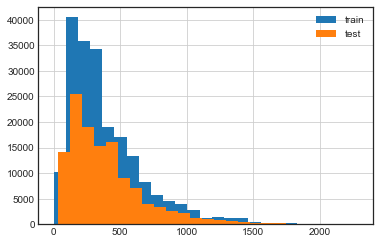

In [74]:
print('Number of days elapsed since first_active_month till 2018-02-01')
train.elapsed_time.hist(bins=25)
test.elapsed_time.hist(bins=25)
ax=plt.gca()
ax.legend(('train', 'test'))

In [11]:
# Combine transactions data
transactions = pd.concat([historical_transactions, new_merchant_transactions])

In [12]:
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y':1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y':1, 'N': 0})

In [13]:
# Create dummy columns
transactions_d = pd.get_dummies(transactions, columns=['category_2', 'category_3'])

In [42]:
# Explore purchase_amount data
print('purchase_amount min and max:')
print('min:', transactions_d.purchase_amount.min())
print('max:', transactions_d.purchase_amount.max())

print('purchase_amount percentile:')
print(transactions_d.purchase_amount.quantile([.01, .25, .5, .75, .99]))

purchase_amount min and max:
min: -0.7469078
max: 6010603.9717525
purchase_amount percentile:
0.01   -0.743166
0.25   -0.719905
0.50   -0.687523
0.75   -0.600865
0.99    1.239597
Name: purchase_amount, dtype: float64


In [15]:
# Winsorize purchase_amount to remove extreme outliers
purchase_amount_lb = transactions_d.purchase_amount.quantile(.01)
purchase_amount_ub = transactions_d.purchase_amount.quantile(.99)

transactions_d['purchase_amount_win'] = transactions_d.purchase_amount.apply(
    lambda x:  purchase_amount_lb if x <= purchase_amount_lb else(
        purchase_amount_ub if x >= purchase_amount_ub else x
    )
)

In [16]:
# Get purchase_month of each transactions
transactions_d['purchase_month'] = transactions_d.purchase_date.apply(
    lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
)

In [17]:
# Collapse transaction level data to card_id level information
df = (transactions_d.groupby('card_id').size().reset_index(name='transactions_count')) # Initiate df

In [18]:
# Purchase amount [sum, mean] 
## Total 
temp_agg = transactions_d.groupby(['card_id'])['purchase_amount_win'].agg(['sum', 'mean'])
temp_agg.columns = ['purchase_amount_sum', 'purchase_amount_mean']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

## Last two months (month_lag >= 1) L60
temp_agg = transactions_d[transactions_d['month_lag'] >= 1].groupby(['card_id'])['purchase_amount_win'].agg(['sum', 'mean'])
temp_agg.columns = ['purchase_amount_sum_l60', 'purchase_amount_mean_l60']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

## Last six months (month_lag between >= -3) L180
temp_agg = transactions_d[transactions_d['month_lag'] >= -3].groupby(['card_id'])['purchase_amount_win'].agg(['sum', 'mean'])
temp_agg.columns = ['purchase_amount_sum_l180', 'purchase_amount_mean_l180']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

In [19]:
# Number of transactions [count]
## Last two months (month_lag >= 1) L60
temp_agg = transactions_d[transactions_d['month_lag'] >= 1].groupby(['card_id']).size().reset_index(name='transactions_count_l60')
df = pd.merge(df, temp_agg, on='card_id', how='left')

## Last six months (month_lag between >= -3) L180
temp_agg = transactions_d[transactions_d['month_lag'] >= -3].groupby(['card_id']).size().reset_index(name='transactions_count_l180')
df = pd.merge(df, temp_agg, on='card_id', how='left')

In [20]:
# Authorized transactions [sum, mean]
## Total 
temp_agg = transactions_d.groupby(['card_id'])['authorized_flag'].agg(['sum', 'mean'])
temp_agg.columns = ['authorized_sum', 'authorized_mean']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

## Last two months (month_lag >= 1) L60
temp_agg = transactions_d[transactions_d['month_lag'] >= 1].groupby(['card_id'])['authorized_flag'].agg(['sum', 'mean'])
temp_agg.columns = ['authorized_sum_l60', 'authorized_mean_l60']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

## Last six months (month_lag between >= -3) L180
temp_agg = transactions_d[transactions_d['month_lag'] >= -3].groupby(['card_id'])['authorized_flag'].agg(['sum', 'mean'])
temp_agg.columns = ['authorized_sum_l180', 'authorized_mean_l180']
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

In [21]:
# Other features
agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['sum', 'mean'],
    'category_2_2.0': ['sum', 'mean'],
    'category_2_3.0': ['sum', 'mean'],
    'category_2_4.0': ['sum', 'mean'],
    'category_2_5.0': ['sum', 'mean'],
    'category_3_A': ['sum', 'mean'],
    'category_3_B': ['sum', 'mean'],
    'category_3_C': ['sum', 'mean'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],    
    'merchant_category_id': ['nunique'],
    'merchant_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount_win': ['max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': ['min', 'max'],
    'month_lag': ['min', 'max']
}

In [22]:
temp_agg = transactions_d.groupby(['card_id']).agg(agg_func)
temp_agg.columns = ['_'.join(col).strip() for col in temp_agg.columns.values]
temp_agg.reset_index(inplace=True)
df = pd.merge(df, temp_agg, on='card_id', how='left')

authorized_mean percentile
0.01    0.500000
0.25    0.866667
0.50    0.933333
0.75    0.975000
0.99    1.000000
Name: authorized_mean, dtype: float64


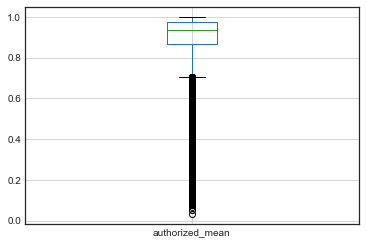

In [48]:
print('authorized_mean percentile')
print(df.authorized_mean.quantile([.01, .25, .5, .75, .99]))
df.boxplot(column='authorized_mean')

In [23]:
df_clean = df.fillna(0)

In [25]:
# Generate dummies for train and test
train_d = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test_d = pd.get_dummies(test, columns=['feature_1', 'feature_2'])

# Attach card summary stats to train and test data
train_clean = pd.merge(train_d, df_clean, on='card_id', how='left')
test_clean = pd.merge(test_d, df_clean, on='card_id', how='left')

In [26]:
# Prepare data for modeling
features_col = [c for c in train_clean.columns if c not in [
    'first_active_month',
    'card_id',
    'target',
    'target_win',
    'purchase_date_min',
    'purchase_date_max',
]]

features = train_clean[features_col].values
labels = train_clean.target_win

----
### Shuffle and Split Data
Split features and labels into training and test set

In [27]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 161533 samples.
Testing set has 40384 samples.


### Benchmark: Naive Predictor Performance
- Use root mean squared error (RMSE) to evaluate performance
- For the naive model, use the training data mean score as the predicted score for the test data

In [28]:
from sklearn.metrics import mean_squared_error
y_pred = [y_train.mean()] * y_test.shape[0]
mean_squared_error(y_test, y_pred) ** 0.5

2.2487432783994192

### Build model

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [76]:
# Build a training and prediction pipeline
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test) and train set (X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute RMSE on the training set
    results['rmse_train'] = mean_squared_error(y_train, predictions_train) ** 0.5
        
    # Compute accuracy on test set
    results['rmse_test'] = mean_squared_error(y_test, predictions_test) ** 0.5

    sample_size = X_train.shape[0]
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [79]:
# Initialize the three models
reg_A = LinearRegression()
reg_B = AdaBoostRegressor(random_state=4)
reg_C = GradientBoostingRegressor(random_state=5)

# Collect results on the learners
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = train_predict(reg, X_train, y_train, X_test, y_test)

LinearRegression trained on 161533 samples.
AdaBoostRegressor trained on 161533 samples.
GradientBoostingRegressor trained on 161533 samples.


In [99]:
results_df = pd.DataFrame.from_dict(results)
results_df

,AdaBoostRegressor,GradientBoostingRegressor,LinearRegression
pred_time,0.610593,0.619945,0.073563
rmse_test,4.511252,2.143555,2.189082
rmse_train,4.511780,2.139898,2.196039
train_time,34.228163,95.940273,0.995987


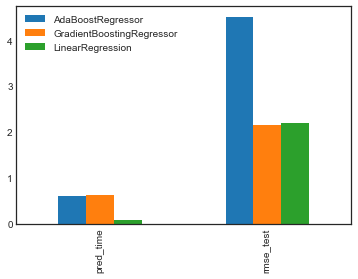

In [105]:
results_df.loc[['pred_time', 'rmse_test'],:].plot.bar()

### GridSearch on hyperparameters

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the regressor
reg = GradientBoostingRegressor(random_state=5)

# GridSearch parameters
parameters = {
    'n_estimators': [100, 120],
    'learning_rate': [.1, .5] 
}

# Make a mean_squared_error scoring object using make_scorer()
scorer = make_scorer(mean_squared_error)

# Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=reg, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_reg = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (reg.fit(X_train, y_train)).predict(X_test)
best_predictions = best_reg.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("RMSE on testing data: {:.4f}".format(mean_squared_error(y_test, predictions)**0.5))
print("\nOptimized Model\n------")
print("RMSE on testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)**0.5))

Unoptimized model
------
RMSE on testing data: 2.1436

Optimized Model
------
RMSE on testing data: 2.1444


In [111]:
reg

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=False)

In [112]:
best_reg

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=False)

In [113]:
# Hand tuned version 1
reg = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1,
                                max_depth=3, random_state=0, loss='ls')

reg.fit(X_train, y_train)

predictions_train = reg.predict(X_train)

predictions_test = reg.predict(X_test)

rmse_train = mean_squared_error(y_train, predictions_train) ** 0.5

rmse_test = mean_squared_error(y_test, predictions_test) ** 0.5

print('training rmse:', rmse_train)
print('testing rmse:', rmse_test)

training rmse: 2.1284491241542534
testing rmse: 2.138064757213247


In [114]:
# Hand tuned version 2
reg = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1,
                                max_depth=3, min_samples_leaf = 2, random_state=0, loss='ls')

reg.fit(X_train, y_train)

predictions_train = reg.predict(X_train)

predictions_test = reg.predict(X_test)

rmse_train = mean_squared_error(y_train, predictions_train) ** 0.5

rmse_test = mean_squared_error(y_test, predictions_test) ** 0.5

print('training rmse:', rmse_train)
print('testing rmse:', rmse_test)

training rmse: 2.1304752915930885
testing rmse: 2.1386255765755786


#### Results:

|     Metric     | Benchmark         | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------:   | :-------------: | 
| RMSE           | 2.2487            |  2.1436           | 2.1381          |


In [135]:
# Cross Validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
reg = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1,
                                max_depth=3, random_state=0, loss='ls')

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
scores = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

In [138]:
print('RMSE for 3-fold cv:', (-scores) ** 0.5)
print('Average RMSE for 3-fold cv:', sum((-scores) ** 0.5)/3)

RMSE for 3-fold cv: [2.16762    2.11905169 2.12290882]
Average RMSE for 3-fold cv: 2.136526837978261


In [ ]:
# For Kaggle submissions - Naive Model

# Assigned the average of mean and median from training set to actual test set and uploaded through Kaggle API
# to the competition; Received a score of 3.935
# test_naive = test.copy()
# test_naive.loc[:, 'target'] = (train_clean['target'].mean() + train_clean['target'].median()) / 2
# test_naive[['card_id', 'target']].to_csv(r'submission_naive.csv', index=False)
# test_naive[['card_id', 'target']].head()

In [117]:
# For Kaggle submissions - Actual Models
test_clean = test_clean.fillna(0)
test_features = test_clean[features_col].values
predictions_true_test = reg.predict(test_features) # Predict target score
true_test_result = pd.Series(predictions_true_test, index=test_clean['card_id'].values) # Format series
true_test_result_df = pd.DataFrame({'card_id':true_test_result.index, 'target':true_test_result.values}) # Format df

Distribution of loyalty scores


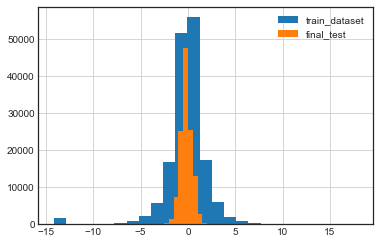

In [118]:
print('Distribution of loyalty scores')
y_train.hist(bins=25)
true_test_result_df['target'].hist(bins=25) # Visualize distribution of target score
ax=plt.gca()
ax.legend(('train_dataset', 'final_test'))

In [119]:
# Save to file
# true_test_result_df.to_csv(r'submission1_adaboost.csv', index=False)
# true_test_result_df.to_csv(r'submission2_gradientboost.csv', index=False)
# true_test_result_df.to_csv(r'submission3_gradientboost2.csv', index=False)